### Inroduction of the Project

I selected MongoDB for this project because it is a distributed NoSQL database that can handle large volumes of data. I installed Docker locally and ran MongoDB using the command
docker run -d --name mongo -p 27017:27017 mongo:7,
which allowed me to use MongoDB without relying on any cloud service or external setup.

Here I used Python with Jupyter Notebook. First, I collected real-world raw data from the NYC 311 public service API. This dataset contains service requests submitted by New York City residents, such as noise complaints, infrastructure issues, and public service problems. The data is in JSON format and I limited it for 50,000 records with attributes like complaint type, borough, time, and geographic location. I performed data cleaning by removing duplicate records, handling missing values, and converting data types such as dates and numeric fields into the correct format. After cleaning, I imported the processed data into MongoDB.

I then verified the number of rows and columns using MongoDB queries and Python. After that, I used MongoDB aggregation pipelines to generate summarized datasets, including complaint counts by borough, weekly trend analysis, and spatial data preparation for the visualization of the results using Matplotlib, creating bar charts, time-series plots, and geographic density plots. 

NYC 311 Service Requests
	It’s big, real, and messy data with many columns. We pull 50,000 rows, and 8 columns, then load to MongoDB.

In [ ]:
import requests, pandas as pd
from dateutil import parser

URL = "https://data.cityofnewyork.us/resource/erm2-nwe9.json"


params = {
    "$select": "unique_key,created_date,agency,complaint_type,borough,latitude,longitude,status",
    "$limit": 50000
}

r = requests.get(URL, params=params, timeout=60)
r.raise_for_status()
data = r.json()

df = pd.DataFrame(data)
df.head(), df.shape

/Users/zubair/Documents/Final_BigData/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


(  unique_key             created_date agency  \
 0   20147743  2011-03-30T13:13:27.000    DOB   
 1   20148279  2011-03-31T12:39:13.000    DHS   
 2   20149530  2011-03-31T00:00:00.000    HPD   
 3   20153498  2011-03-30T11:27:56.000    DOB   
 4   20153707  2011-04-01T10:20:00.000   DSNY   
 
                             complaint_type    borough            latitude  \
 0                             Building/Use      BRONX   40.86278028962927   
 1           DHS Advantage -Landlord/Broker   BROOKLYN                 NaN   
 2                                  HEATING      BRONX   40.85789495216717   
 3  Special Projects Inspection Team (SPIT)  MANHATTAN  40.779875543029725   
 4        Missed Collection (All Materials)     QUEENS   40.75045377460734   
 
             longitude  status  
 0  -73.90163545687834  Closed  
 1                 NaN  Closed  
 2  -73.89872897915322  Closed  
 3  -73.98255271981678  Closed  
 4  -73.89390080872364  Closed  ,
 (50000, 8))

Basic cleaning

In [ ]:

cols = ["unique_key","created_date","agency","complaint_type","borough","latitude","longitude","status"]
df = df[cols].copy()

df["unique_key"] = pd.to_numeric(df["unique_key"], errors="coerce").astype("Int64")
df["created_date"] = pd.to_datetime(df["created_date"], errors="coerce", utc=True)

for c in ["latitude","longitude"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["unique_key","created_date","complaint_type","borough"])



(50000, 8)

Importing into MongoDB

In [ ]:
from pymongo import MongoClient, ASCENDING
from pymongo.errors import BulkWriteError

client = MongoClient("mongodb://localhost:27017")  
col = db["nyc311"]

col.create_index([("unique_key", ASCENDING)], unique=True)


docs = df.to_dict("records")
try:
    res = col.insert_many(docs, ordered=False)
    print("Inserted:", len(res.inserted_ids))
except BulkWriteError as e:
    
    inserted = e.details.get("nInserted", 0)
    print("Inserted:", inserted, "| duplicates skipped by unique index")

Inserted: 50000


Number of Rows and Columns 

In [14]:

row_count = col.count_documents({})
row_count

50000

In [ ]:


sample = col.find_one({}, {"_id": 0})
num_cols = len(sample.keys())
num_cols, sample.keys()

(8,
 dict_keys(['unique_key', 'created_date', 'agency', 'complaint_type', 'borough', 'latitude', 'longitude', 'status']))

Clean DB (find & remove duplicates, empty fields)

In [6]:
pipeline_dupes = [
    {"$group": {"_id": "$unique_key", "n": {"$sum": 1}}},
    {"$match": {"n": {"$gt": 1}}},
    {"$limit": 10}
]
list(col.aggregate(pipeline_dupes))

[]

Removing records with empty strings in some fields

In [7]:
delete_result = col.delete_many({
    "$or": [
        {"complaint_type": {"$in": [None, ""]}},
        {"borough": {"$in": [None, ""]}},
        {"created_date": {"$in": [None, ""]}}
    ]
})
delete_result.deleted_count

0

 Aggregations 

Top complaint types by borough (stacked bar)

Matplotlib is building the font cache; this may take a moment.


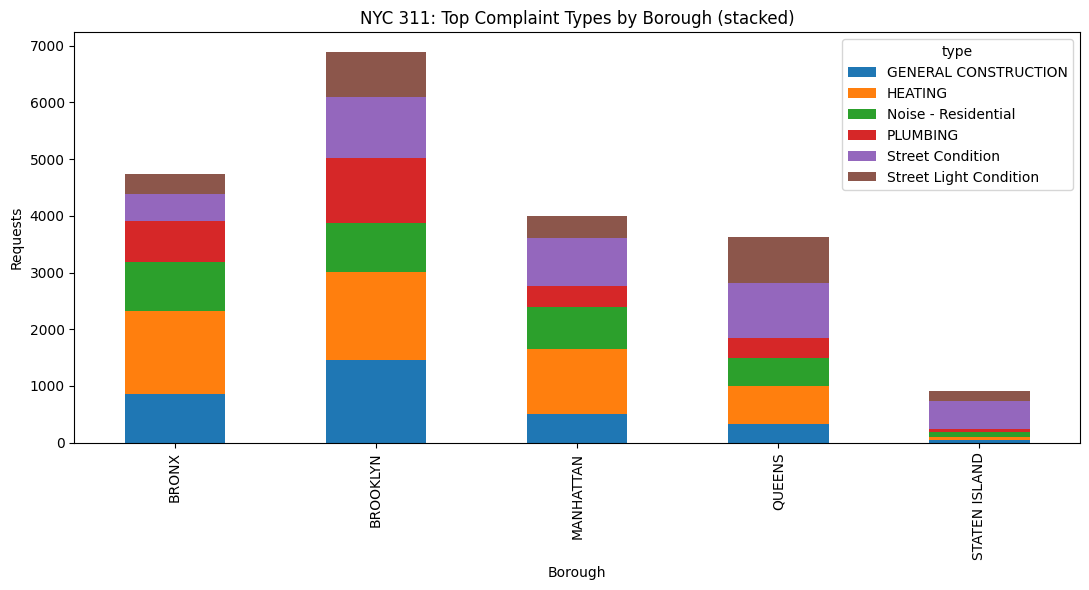

In [ ]:
import matplotlib.pyplot as plt

pipeline = [
    {"$match": {"borough": {"$ne": None}, "complaint_type": {"$ne": None}}},
    {"$group": {"_id": {"borough":"$borough","type":"$complaint_type"}, "cnt": {"$sum": 1}}},
    {"$sort": {"cnt": -1}},
    {"$limit": 200}  
]
rows = list(col.aggregate(pipeline))
agg = pd.DataFrame([{"borough": r["_id"]["borough"], "type": r["_id"]["type"], "cnt": r["cnt"]} for r in rows])


top_types = agg.groupby("type")["cnt"].sum().sort_values(ascending=False).head(6).index
plot_df = agg[agg["type"].isin(top_types)].pivot_table(index="borough", columns="type", values="cnt", aggfunc="sum", fill_value=0)

ax = plot_df.sort_index().plot(kind="bar", stacked=True, figsize=(11,6))
ax.set_title("NYC 311: Top Complaint Types by Borough (stacked)")
ax.set_xlabel("Borough")
ax.set_ylabel("Requests")
plt.tight_layout()
plt.show()

Trend over time 

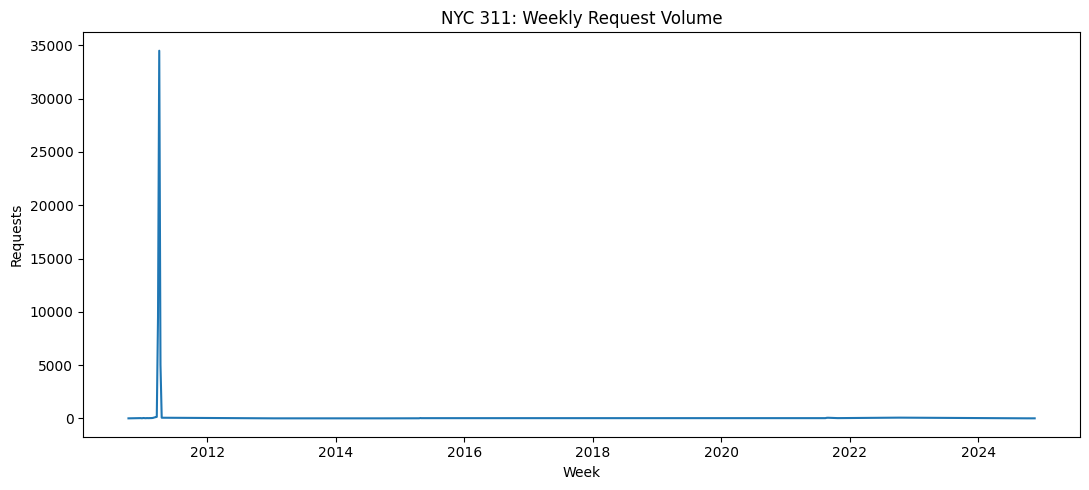

In [9]:
pipeline = [
    {"$match": {"created_date": {"$ne": None}}},
    {"$project": {"week": {"$dateTrunc": {"date":"$created_date", "unit":"week"}}}},
    {"$group": {"_id": "$week", "cnt": {"$sum": 1}}},
    {"$sort": {"_id": 1}}
]
rows = list(col.aggregate(pipeline))
ts = pd.DataFrame(rows).rename(columns={"_id":"week"}).sort_values("week")

plt.figure(figsize=(11,5))
plt.plot(ts["week"], ts["cnt"])
plt.title("NYC 311: Weekly Request Volume")
plt.xlabel("Week")
plt.ylabel("Requests")
plt.tight_layout()
plt.show()

Geo density (hexbin) of complaints

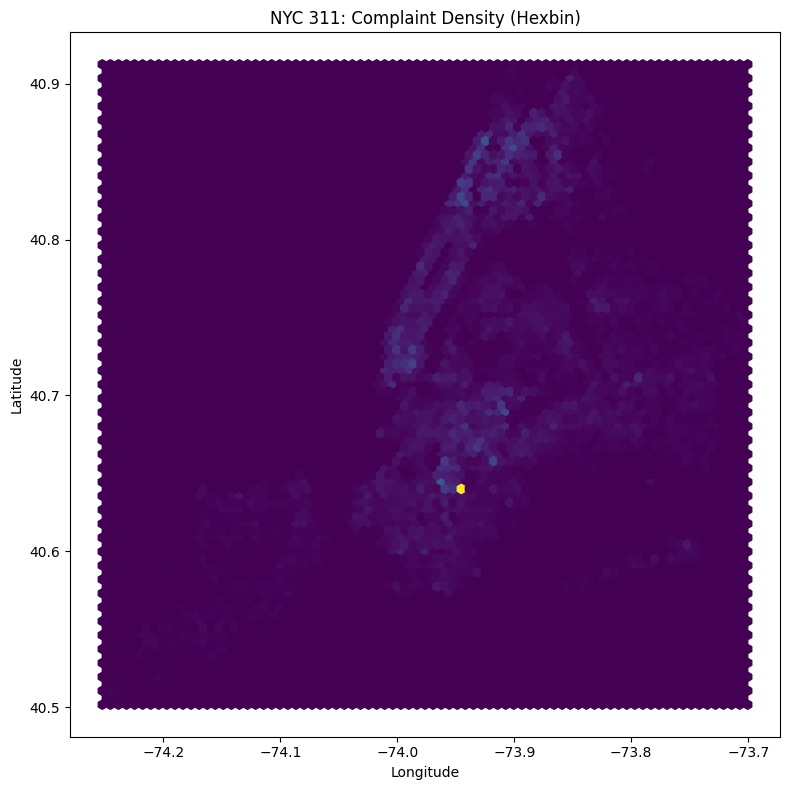

In [ ]:
pipeline = [
    {"$match": {"latitude": {"$ne": None}, "longitude": {"$ne": None}}},
    {"$project": {"lat":"$latitude","lon":"$longitude"}}
]
rows = list(col.aggregate(pipeline))
geo = pd.DataFrame(rows)

plt.figure(figsize=(8,8))
plt.hexbin(geo["lon"], geo["lat"], gridsize=80) 
plt.title("NYC 311: Complaint Density (Hexbin)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

In [11]:
col.create_index([("borough", 1), ("created_date", -1)])
print(col.find({"borough":"BROOKLYN"}).sort("created_date", -1).limit(5).explain()["queryPlanner"]["winningPlan"])

{'stage': 'LIMIT', 'limitAmount': 5, 'inputStage': {'stage': 'FETCH', 'inputStage': {'stage': 'IXSCAN', 'keyPattern': {'borough': 1, 'created_date': -1}, 'indexName': 'borough_1_created_date_-1', 'isMultiKey': False, 'multiKeyPaths': {'borough': [], 'created_date': []}, 'isUnique': False, 'isSparse': False, 'isPartial': False, 'indexVersion': 2, 'direction': 'forward', 'indexBounds': {'borough': ['["BROOKLYN", "BROOKLYN"]'], 'created_date': ['[MaxKey, MinKey]']}}}}


### Conclusions
- Brooklyn and Bronx generate the highest number of complaints.
- Street light complaints are higher than many other complaint types in each borough.